# Cognitive Modeling - Assignment 2
Yorick Juffer \
s1993623

## Libraries

In [1]:
import math
import random

from model import Model
from dmchunk import Chunk

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Functions

In [2]:
t_0 = 0.011
a = 1.1
b = 0.015
add_noise = True

def noise(s):
    rand = random.uniform(0.001, 0.999)
    return s * math.log((1 - rand)/rand)

def time_to_pulses(time, t_0 = t_0, a = a, b = b, add_noise = add_noise):  
    pulses = 0
    pulse_duration = t_0
    
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
        
    return pulses

def pulses_to_time(pulses, t_0 = t_0, a = a, b = b, add_noise = add_noise):
    time = 0
    pulse_duration = t_0
    
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    
    return time

## Experiment

In [3]:
def experiment(participants):

    intertrial_interval = []
    reward_visibility = [
        [0, 0], 
        [1, 0], 
        [1, 1], 
        [0, 1]]
    foreperiod_location = [
        [0.3, 0],
        [0.3, 1],
        [0.6, 0],
        [0.6, 1],
        [0.9, 0],
        [0.9, 1]]

    # visibility 0 = poor
    # location 0 = left
    
    recording_data = False
    count = 0
    for participant in range(participants):

        # prep the model, add a single instance to avoid an error with NoneType
        participant_model = Model()
        random.shuffle(foreperiod_location)
        pulses = time_to_pulses(foreperiod_location[0][0])
        chunk = Chunk(name = "time" + "train", slots = {"type": "time", "value": pulses})
        participant_model.add_encounter(chunk)
        participant_model.time += 0.1

        # shuffle the lists
        random.shuffle(reward_visibility)
        random.shuffle(foreperiod_location)

        index_block = 0
        index_trial = 0

        for block in range(16):

            if(index_block == 4):
                random.shuffle(reward_visibility)
                index_block = 0
            
            for trial in range(30):

                if(index_trial == 6):
                    random.shuffle(foreperiod_location)
                    index_trial = 0

                # constants
                reaction_time = 0.410
                reward_time = 0.05
                visibility_time = 0.05

                # pre stimulus
                blend_pattern = Chunk(name = "foreperiod", slots = {"type": "time"})
                memory = participant_model.retrieve_blended_trace(blend_pattern, "value")
                anticipation = 0.5

                # stimulus
                difference = foreperiod_location[index_trial][0] - pulses_to_time(memory[0] * anticipation)
                participant_model.time += memory[1] + 0.05

                reaction_time = reaction_time - (reward_time * reward_visibility[index_block][0]) - (visibility_time * reward_visibility[index_block][1])

                if(not recording_data):
                    results = np.array([[participant, block, trial, reward_visibility[index_block][0], reward_visibility[index_block][1], foreperiod_location[index_trial][0], foreperiod_location[index_trial][1], reaction_time]])
                    recording_data = True
                else:
                    results = np.append(results, [[participant, block, trial, reward_visibility[index_block][0], reward_visibility[index_block][1], foreperiod_location[index_trial][0], foreperiod_location[index_trial][1], reaction_time]], axis=0)
                
                # post stimulus
                pulses = time_to_pulses(foreperiod_location[index_trial][0])
                chunk = Chunk(name = "time" + str(count), slots = {"type": "time", "value": pulses})
                participant_model.add_encounter(chunk)
                count += 1
                participant_model.time += 0.1

                # simple printout to see progress.
                print("Participant: {}/{}".format(participant + 1, participants), end="\r")

                index_trial += 1
            index_block += 1

    return results 

## Run the Experiment

In [4]:
data = experiment(10)

## Data Analysis

<AxesSubplot: xlabel='reward,visibility,foreperiod'>

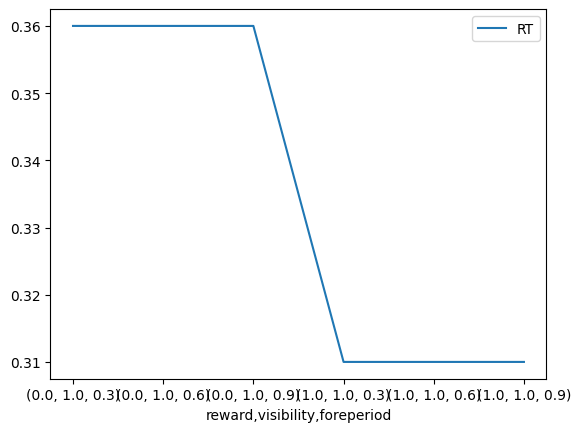

In [44]:
# keep a copy
dataFrame = pd.DataFrame(data)
dataFrame.columns = ["participant", "block", "trial", "reward", "visibility", "foreperiod", "location", "RT"]

dataFrame.drop('participant', inplace=True, axis=1)
dataFrame.drop('block', inplace=True, axis=1)
dataFrame.drop('trial', inplace=True, axis=1)
dataFrame.drop('location', inplace=True, axis=1)
grouped = dataFrame.groupby(["reward", "visibility", "foreperiod"]).mean()

df1, df2 = grouped.query('visibility == 1'), grouped.query('visibility == 0')

df1
# df2


df1.plot(kind="line", )


# # df1.plot(subplots=True, layout=(1,2))


# # print(df1)

# # plt.plot(grouped)
# # # plt.show()

